# 问题
1. 生成点数量是否和精度相关
2. (0,0)点取不到

# 掉包

In [2]:
!pip install scikit-optimize

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [1]:
!pip install seaborn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import torch.nn.functional as F
from skopt import BayesSearchCV
from skopt.space import Real
from skopt import gp_minimize
import torch.nn as nn
import seaborn as sns
from scipy.optimize import minimize
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib as mpl
from skopt.utils import use_named_args
from tqdm import tqdm
import multiprocessing
import threading

In [2]:
# 设置GPU设备，如果没有可用的GPU，则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(888888)

print(device)

cpu


# 基础参数

In [3]:
# 基础参数
epochs = 350001    # 训练代数
h = 100    # 画图网格密度
N = 100    # 内点配置点数
N1 = 0.01    # 边界点配置点数
N2 = 1000    # PDE数据点

# 约束函数

## 内点约束

### 第一象限

In [4]:
def ugeq_1(n=N2):
    x = torch.rand(n, 1, device=device)
    y = torch.rand(n, 1, device=device)
    cond = torch.zeros_like(y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

def pde_1(n=N2):
    x = torch.rand(n, 1, device=device)
    y = torch.rand(n, 1, device=device)
    cond = 2 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

def JU_1(n=N2):
    # 不等式形
    x = torch.rand(n, 1, device=device)
    y = torch.rand(n, 1, device=device)
    cond = 2 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

### 第二象限

In [5]:
def ugeq_2(n=N2):
    x = -torch.rand(n, 1, device=device)
    y = torch.rand(n, 1, device=device)
    cond = torch.zeros_like(y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

def pde_2(n=N2):
    x = -torch.rand(n, 1, device=device)
    y = torch.rand(n, 1, device=device)
    cond = torch.relu( 2 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) )
    return x.requires_grad_(True), y.requires_grad_(True), cond

def JU_2(n=N2):
    x = -torch.rand(n, 1, device=device)
    y = torch.rand(n, 1, device=device)
    cond = 2 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

### 第三象限

In [6]:
def ugeq_3(n=N2):
    x = -torch.rand(n, 1, device=device)
    y = -torch.rand(n, 1, device=device)
    cond = torch.zeros_like(y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

def pde_3(n=N2):
    x = -torch.rand(n, 1, device=device)
    y = -torch.rand(n, 1, device=device)
    cond = torch.relu( 2 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) )
    return x.requires_grad_(True), y.requires_grad_(True), cond

def JU_3(n=N2):
    x = -torch.rand(n, 1, device=device)
    y = -torch.rand(n, 1, device=device)
    cond = 2 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

### 第四象限

In [7]:
def ugeq_4(n=N2):
    x = torch.rand(n, 1, device=device)
    y = -torch.rand(n, 1, device=device)
    cond = torch.zeros_like(y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

def pde_4(n=N2):
    x = torch.rand(n, 1, device=device)
    y = -torch.rand(n, 1, device=device)
    cond = torch.relu( 2 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) )
    return x.requires_grad_(True), y.requires_grad_(True), cond

def JU_4(n=N2):
    # 不等式形
    x = torch.rand(n, 1, device=device)
    y = -torch.rand(n, 1, device=device)
    cond = 2 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

## 边界条件

In [7]:
# 边界条件
def boundary1(n=N1):    # 下边界
    x = -torch.arange(0, 1.001, N1, device=device).view(-1, 1)
    y = -torch.ones_like(x, device=device)
    cond = torch.zeros_like(x, device=device)
    return x.requires_grad_(True), y.requires_grad_(True), cond


def boundary2(n=N1):    # 上边界
    x = torch.arange(-1.001, 1.001, N1, device=device).view(-1, 1)
    y = torch.ones_like(x, device=device)
    cond = torch.zeros_like(x, device=device)
    return x.requires_grad_(True), y.requires_grad_(True), cond

def boundary3(n=N1):    # 左边界
    y = -torch.arange(0, 1.001, N1, device=device).view(-1, 1)
    x = -torch.ones_like(y, device=device)
    cond = torch.zeros_like(x, device=device)
    return x.requires_grad_(True), y.requires_grad_(True), cond

def boundary4(n=N1):    # 右边界
    y = -torch.arange(0, 1.001, N1, device=device).view(-1, 1)
    x = torch.ones_like(y, device=device)
    cond = torch.zeros_like(x, device=device)
    return x.requires_grad_(True), y.requires_grad_(True), cond

def boundary5(n=N1):
    # y轴
    y = -torch.arange(0, 1.001, N1, device=device).view(-1, 1)
    x = torch.zeros_like(y, device=device)
    cond = torch.zeros_like(x, device=device)
    return x.requires_grad_(True), y.requires_grad_(True), cond

def boundary6(n=N1):
    # x轴
    x = -torch.arange(0, 1.001, N1, device=device).view(-1, 1)
    y = torch.zeros_like(x, device=device)
    cond = torch.zeros_like(x, device=device)
    return x.requires_grad_(True), y.requires_grad_(True), cond

# PINNS架构

In [8]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# 损失函数

In [9]:
# Loss
loss = torch.nn.MSELoss()

# 递归求导
def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                   create_graph=True,
                                   only_inputs=True, )[0]
    else:
        return gradients(gradients(u, x), x, order=order - 1)

## 内点

### 第一象限

In [10]:
def l_ugeq1(u):
    # u>=0
    x, y, cond = ugeq_1()
    uxy = u(torch.cat([x, y], dim=1))
    llos = torch.relu(-uxy)
    return 100 * torch.sum(llos)

def l_pde1(u):
    # 等式项损失
    x, y, cond = pde_1()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(-gradients(uxy, x, 2) - gradients(uxy, y, 2), cond)

def l_JU1(u):
    # 不等式损失
    x, y, cond = JU_1()
    uxy = u(torch.cat([x, y], dim=1))
    llos = 0.5 * (gradients(uxy, x, 1)**2 + gradients(uxy, y, 1)**2) - cond * uxy
    return loss(0.5 * (gradients(uxy, x, 1)**2 + gradients(uxy, y, 1)**2), cond * uxy)

### 第二象限

In [11]:
def l_ugeq2(u):
    # u>=0
    x, y, cond = ugeq_2()
    uxy = u(torch.cat([x, y], dim=1))
    llos = torch.relu(-uxy)
    return 100 * torch.sum(llos)

def l_pde2(u):
    # 等式项损失
    x, y, cond = pde_2()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(-gradients(uxy, x, 2) - gradients(uxy, y, 2), cond)

def l_JU2(u):
    # 不等式损失
    x, y, cond = JU_2()
    uxy = u(torch.cat([x, y], dim=1))
    llos = 0.5 * (gradients(uxy, x, 1)**2 + gradients(uxy, y, 1)**2) - cond * uxy
    return loss(0.5 * (gradients(uxy, x, 1)**2 + gradients(uxy, y, 1)**2), cond * uxy)

### 第三象限

In [11]:
def l_ugeq3(u):
    # u>=0
    x, y, cond = ugeq_3()
    uxy = u(torch.cat([x, y], dim=1))
    llos = torch.relu(-uxy)
    return 100 * torch.sum(llos)

def l_pde3(u):
    # 等式项损失
    x, y, cond = pde_3()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(-gradients(uxy, x, 2) - gradients(uxy, y, 2), cond)

def l_JU3(u):
    # 不等式损失
    x, y, cond = JU_3()
    uxy = u(torch.cat([x, y], dim=1))
    llos = 0.5 * (gradients(uxy, x, 1)**2 + gradients(uxy, y, 1)**2) - cond * uxy
    return loss(0.5 * (gradients(uxy, x, 1)**2 + gradients(uxy, y, 1)**2), cond * uxy)

### 第四象限

In [11]:
def l_ugeq4(u):
    # u>=0
    x, y, cond = ugeq_4()
    uxy = u(torch.cat([x, y], dim=1))
    llos = torch.relu(-uxy)
    return 100 * torch.sum(llos)

def l_pde4(u):
    # 等式项损失
    x, y, cond = pde_4()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(-gradients(uxy, x, 2) - gradients(uxy, y, 2), cond)

def l_JU4(u):
    # 不等式损失
    x, y, cond = JU_4()
    uxy = u(torch.cat([x, y], dim=1))
    llos = 0.5 * (gradients(uxy, x, 1)**2 + gradients(uxy, y, 1)**2) - cond * uxy
    return loss(0.5 * (gradients(uxy, x, 1)**2 + gradients(uxy, y, 1)**2), cond * uxy)

## 边界损失

In [12]:
# 边界函数构建
def l_boundary1(u):
    x, y, cond = boundary1()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

def l_boundary2(u):
    x, y, cond = boundary2()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

def l_boundary3(u):
    x, y, cond = boundary3()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

def l_boundary4(u):
    x, y, cond = boundary4()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

def l_boundary5(u):
    x, y, cond = boundary5()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

def l_boundary6(u):
    x, y, cond = boundary6()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

# 训练

In [ ]:
# Training
u = MLP().to(device)
opt = torch.optim.Adam(params=u.parameters(), lr=0.0005)

# 初始化损失记录器
all_losses = []
pde_losses = []
boundary_losses = []
initial_losses = []
current_time = time.time()
maxerror = 99999999999

# 设置初始权重
weight_pde = 60
weight_JU = 2
weight_boundary = 1000


for i in range(epochs):

    opt.zero_grad()

    # 计算损失
    loss_pde = l_pde3(u)
    loss_JU = l_JU3(u)
    loss_ugeq = l_ugeq3(u)
    loss_boundary = l_boundary1(u) +  l_boundary3(u) + l_boundary5(u) + l_boundary6(u)
    # predictions = sum(abs(u(points)))

    # 计算加权总损失
    total_loss = weight_pde * loss_pde + weight_JU * loss_JU + 600 * loss_ugeq + weight_boundary * loss_boundary

    # 反向传播和优化
    total_loss.backward()
    opt.step()

    # 每100次迭代记录一次损失
    if i % 100 == 0:
        # 记录损失
        all_losses.append(total_loss.item())
        pde_losses.append(loss_pde.item())
        boundary_losses.append(loss_boundary.item())
        
        xc_x = -torch.linspace(0, 1, h, device=device)
        xc_y = -torch.linspace(0, 1, h, device=device)
        xm, ym = torch.meshgrid(xc_x, xc_y)
        xx = xm.reshape(-1, 1)         
        yy = ym.reshape(-1, 1)               
        xy = torch.cat([xx, yy], dim=1).to(device)
        # 计算预测值和真实值
        u_pred = u(xy)
        u_real = ( torch.sin(torch.pi * xx) * torch.sin(torch.pi * yy) )
        u_real = torch.relu(u_real)
        u_error = torch.abs(u_pred - u_real)
        u_pred_fig = u_pred.reshape(h, h)
        u_real_fig = u_real.reshape(h, h)
        u_error_fig = u_error.reshape(h, h)
        print(f"At epoch {i}, time_speed:{abs(current_time-time.time())} Max abs error is: {float(torch.max(u_error))}, now:{maxerror}")
        print(f"ueq:{l_ugeq3(u).data}, 1:{l_boundary1(u)}, 2:{l_boundary3(u)}, 3:{l_boundary5(u)}, 4:{l_boundary6(u)}")
        print('-----------------------------------------------------------------------------------------------------------------------')
        #模型保存权重
        if torch.max(u_error) < maxerror:
            maxerror = torch.max(u_error)
            torch.save(u.state_dict(), 'weights3.pth')
        current_time = time.time()


At epoch 0, time_speed:0.09419417381286621 Max abs error is: 0.9118552207946777, now:99999999999
ueq:0.0, 1:0.008740031160414219, 2:0.010202154517173767, 3:0.006814691238105297, 4:0.0075146290473639965
-----------------------------------------------------------------------------------------------------------------------
At epoch 100, time_speed:4.805032730102539 Max abs error is: 0.8778243064880371, now:0.9118552207946777
ueq:0.0, 1:0.021158229559659958, 2:0.014148024842143059, 3:0.01493009738624096, 4:0.007688925601541996
-----------------------------------------------------------------------------------------------------------------------
At epoch 200, time_speed:2.5955772399902344 Max abs error is: 0.8765747547149658, now:0.8778243064880371
ueq:0.0, 1:0.024505214765667915, 2:0.014174443669617176, 3:0.014751272276043892, 4:0.00448963325470686
-----------------------------------------------------------------------------------------------------------------------
At epoch 300, time_spee

# 画图

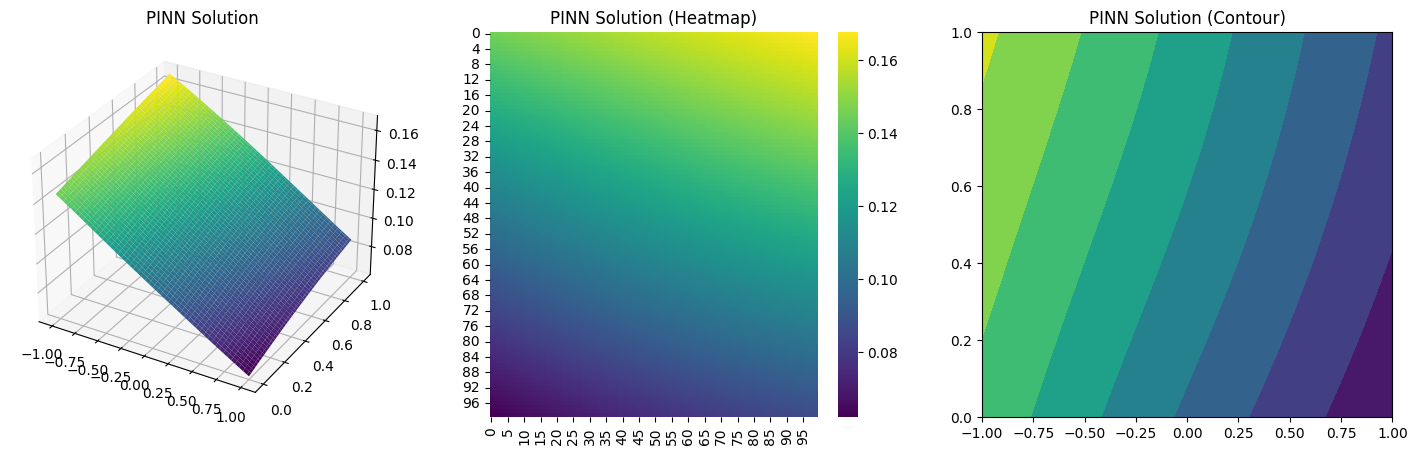

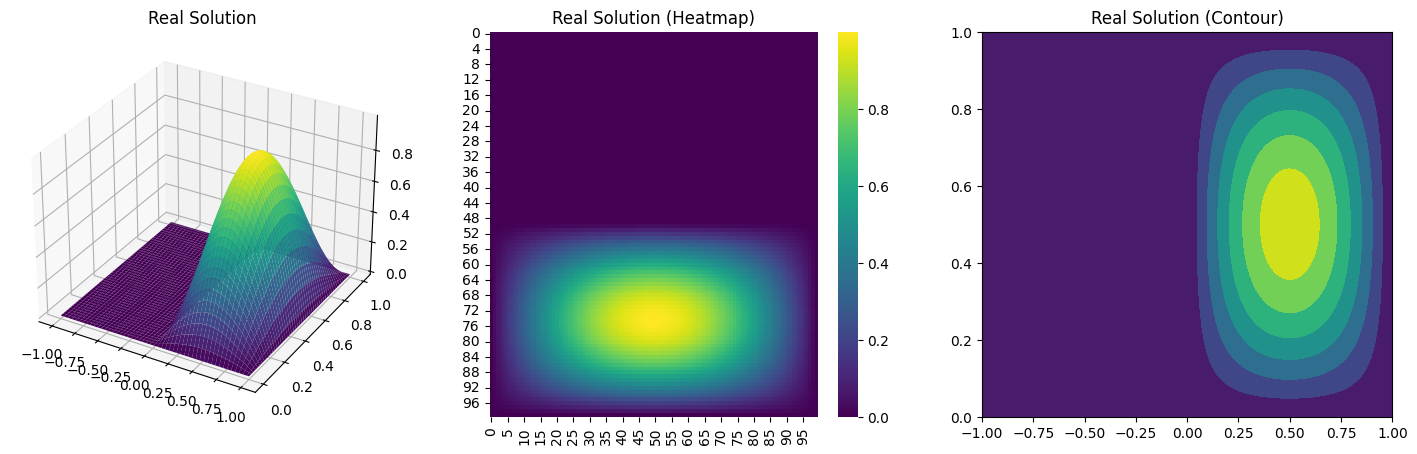

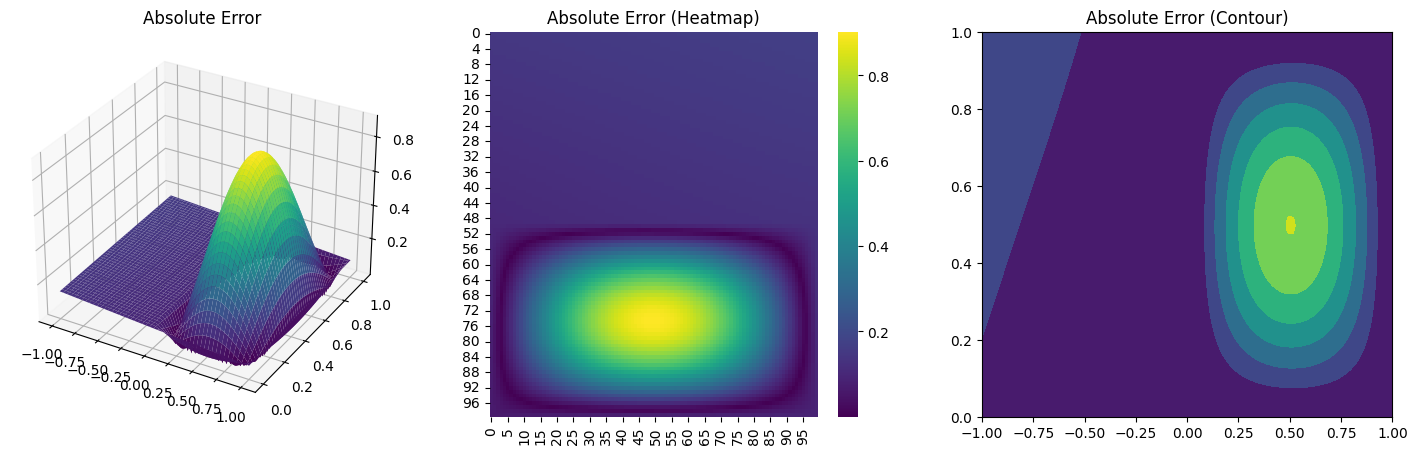

In [12]:
# 作PINN数值解图
fig = plt.figure(figsize=(18, 5))  # 调整图大小

# 3D plot
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(xm.cpu().detach().numpy(), ym.cpu().detach().numpy(), u_pred_fig.cpu().detach().numpy(), cmap='viridis')
ax.set_title("PINN Solution")

# Heatmap
ax = fig.add_subplot(132)
sns.heatmap(u_pred_fig.cpu().detach().numpy(), cmap='viridis', ax=ax)
ax.set_title("PINN Solution (Heatmap)")

# 2D plot
ax = fig.add_subplot(133)
ax.contourf(xm.cpu().detach().numpy(), ym.cpu().detach().numpy(), u_pred_fig.cpu().detach().numpy(), cmap='viridis')
ax.set_title("PINN Solution (Contour)")

plt.show()

# 作真实解图
fig = plt.figure(figsize=(18, 5))  # 调整图大小

# 3D plot
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(xm.cpu().detach().numpy(), ym.cpu().detach().numpy(), u_real_fig.cpu().detach().numpy(), cmap='viridis')
ax.set_title("Real Solution")

# Heatmap
ax = fig.add_subplot(132)
sns.heatmap(u_real_fig.cpu().detach().numpy(), cmap='viridis', ax=ax)
ax.set_title("Real Solution (Heatmap)")

# 2D plot
ax = fig.add_subplot(133)
ax.contourf(xm.cpu().detach().numpy(), ym.cpu().detach().numpy(), u_real_fig.cpu().detach().numpy(), cmap='viridis')
ax.set_title("Real Solution (Contour)")

plt.show()

# 绘制误差图
fig = plt.figure(figsize=(18, 5))  # 调整图大小

# 3D plot
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(xm.cpu().detach().numpy(), ym.cpu().detach().numpy(), u_error_fig.cpu().detach().numpy(), cmap='viridis')
ax.set_title("Absolute Error")

# Heatmap
ax = fig.add_subplot(132)
sns.heatmap(u_error_fig.cpu().detach().numpy(), cmap='viridis', ax=ax)
ax.set_title("Absolute Error (Heatmap)")

# 2D plot
ax = fig.add_subplot(133)
ax.contourf(xm.cpu().detach().numpy(), ym.cpu().detach().numpy(), u_error_fig.cpu().detach().numpy(), cmap='viridis')
ax.set_title("Absolute Error (Contour)")

plt.show()
